In [1]:
"""
Edge Detection
(Due date: March 6th, 11: 59 P.M.)

The goal of this task is to experiment with two commonly used edge detection operator, i.e., Prewitt operator and Sobel operator,
and familiarize you with 'tricks', e.g., padding, commonly used by computer vision 'researchers'.

Please complete all the functions that are labelled with '# TODO'. Hints or steps are provided to make your lives easier.
Whem implementing the functions, comment the lines 'raise NotImplementedError' instead of deleting them. As we have
written lots of utility functions for you, you only need to write about 30 lines of code. The functions defined in utils.py
are building blocks you could use when implementing the functions labelled with 'TODO'.

I strongly suggest you to read the function zero_pad that is defined in utils.py. It is quite important!

Do NOT modify the code provided.
Do NOT use any API provided by opencv (cv2) and numpy (np) in your code.
Do NOT import any library (function, module, etc.).
"""

import argparse
import copy
import os

import cv2
import numpy as np

import utils

# Prewitt operator
prewitt_x = [[1, 0, -1]] * 3
prewitt_y = [[1] * 3, [0] * 3, [-1] * 3]

# Sobel operator
sobel_x = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]
sobel_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

In [9]:
def parse_args():
    parser = argparse.ArgumentParser(description="cse 473/573 project 1.")
    parser.add_argument(
        "--img_path", type=str, default="",
        help="path to the image used for edge detection")
    parser.add_argument(
        "--kernel", type=str, default="sobel",
        choices=["prewitt", "sobel", "Prewitt", "Sobel"],
        help="type of edge detector used for edge detection")
    parser.add_argument(
        "--result_saving_directory", dest="rs_directory", type=str, default="./results/",
        help="directory to which results are saved (do not change this arg)")
    args = parser.parse_args()
    return args


def read_image(img_path, show=True):
    """Reads an image into memory as a grayscale array.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if not img.dtype == np.uint8:
        pass

    if show:
        show_image(img)

    img = [list(row) for row in img]
    return img

def show_image(img, delay=1000):
    cv2.namedWindow('image', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('image', img)
    cv2.waitKey(delay)
    cv2.destroyAllWindows()

def write_image(img, img_saving_path):
    if isinstance(img, list):
        img = np.asarray(img, dtype=np.uint8)
    elif isinstance(img, np.ndarray):
        if not img.dtype == np.uint8:
            assert np.max(img) <= 1, "Maximum pixel value {:.3f} is greater than 1".format(np.max(img))
            img = (255 * img).astype(np.uint8)
    else:
        raise TypeError("img is neither a list nor a ndarray.")

    cv2.imwrite(img_saving_path, img)

def convolve2d(img, kernel):
    """Convolves a given image and a given kernel.

    Steps:
        (1) flips the either the img or the kernel.
        (2) pads the img or the flipped img.
            this step handles pixels along the border of the img,
            and makes sure that the output img is of the same size as the input image.
        (3) applies the flipped kernel to the image or the kernel to the flipped image,
            using nested for loop.

    Args:
        img: nested list (int), image.
        kernel: nested list (int), kernel.

    Returns:
        img_conv: nested list (int), image.
    """
    # TODO: implement this function.
    
    # Image dimensions
    m, n = len(img), len(img[0])

    # Filter dimensions
    k, l = len(kernel), len(kernel[0])
    
    flipped_filter = utils.flip_x(kernel)
    img_padded = utils.zero_pad(img, k - 1, l - 1)

    img_conv = [[0 for _ in range(n)] for _ in range(m)]
    

    for i in range(m):
        for j in range(n):
            img_ = utils.crop(img_padded, i, i + k, j, j + l)
            mul = utils.elementwise_mul(img_, flipped_filter)
            img_conv[i][j] = sum([sum(x) for x in mul])

    return img_conv


def normalize(img):
    """Normalizes a given image.

    Hints:
        Normalize a given image using the following equation:

        normalized_img = frac{img - min(img)}{max(img) - min(img)},

        so that the maximum pixel value is 255 and the minimum pixel value is 0.

    Args:
        img: nested list (int), image.

    Returns:
        normalized_img: nested list (int), normalized image.
    """
    # TODO: implement this function.
    img_max = max((max(x) for x in img))
    img_min = min((min(x) for x in img))

    for i in range(len(img)):
        for j in range(len(img[0])):
            img[i][j] = (img[i][j] - img_min) * 255. / (img_max - img_min)
            if img[i][j] <= 0.:
                img[i][j] = 0.
    return img


def detect_edges(img, kernel, norm=True):
    """Detects edges using a given kernel.

    Args:
        img: nested list (int), image.
        kernel: nested list (int), kernel used to detect edges.
        norm (bool): whether to normalize the image or not.

    Returns:
        img_edge: nested list (int), image containing detected edges.
    """
    # TODO: detect edges using convolve2d and normalize the image containing detected edges using normalize.
    img_edges = convolve2d(img, kernel)
    show_image(np.array(img_edges))
    
    if norm:
        img_edges = normalize(img_edges)
    
    return img_edges


def edge_magnitude(edge_x, edge_y):
    """Calculate magnitude of edges by combining edges along two orthogonal directions.

    Hints:
        Combine edges along two orthogonal directions using the following equation:

        edge_mag = sqrt(edge_x ** 2 + edge_y ** 2).

        Make sure that you normalize the edge_mag, so that the maximum pixel value is 1.

    Args:
        edge_x: nested list (int), image containing detected edges along one direction.
        edge_y: nested list (int), image containing detected edges along another direction.

    Returns:
        edge_mag: nested list (int), image containing magnitude of detected edges.
    """
    # TODO: implement this function.
    edge_x = utils.elementwise_mul(edge_x, edge_x)
    edge_y = utils.elementwise_mul(edge_y, edge_y)

    edge_mag = utils.elementwise_add(edge_x, edge_y)
    edge_mag = utils.img_sqrt(edge_mag)

    return edge_mag


def main():
    args = parse_args()

    img = read_image(args.img_path)

    if args.kernel in ["prewitt", "Prewitt"]:
        kernel_x = prewitt_x
        kernel_y = prewitt_y
    elif args.kernel in ["sobel", "Sobel"]:
        kernel_x = sobel_x
        kernel_y = sobel_y
    else:
        raise ValueError("Kernel type not recognized.")

    if not os.path.exists(args.rs_directory):
        os.makedirs(args.rs_directory)

    img_edge_x = detect_edges(img, kernel_x, False)
    img_edge_x = np.asarray(img_edge_x)
    write_image(normalize(img_edge_x), os.path.join(args.rs_directory, "{}_edge_x.jpg".format(args.kernel.lower())))

    img_edge_y = detect_edges(img, kernel_y, False)
    img_edge_y = np.asarray(img_edge_y)
    write_image(normalize(img_edge_y), os.path.join(args.rs_directory, "{}_edge_y.jpg".format(args.kernel.lower())))

    img_edges = edge_magnitude(img_edge_x, img_edge_y)
    write_image(img_edges, os.path.join(args.rs_directory, "{}_edge_mag.jpg".format(args.kernel.lower())))



In [10]:
img = read_image("data/sample.jpg")

img_edge_x = detect_edges(img, sobel_x, False)
img_edge_x = np.asarray(img_edge_x)

img_edge_y = detect_edges(img, sobel_x, False)
img_edge_y = np.asarray(img_edge_y)

img_edges = edge_magnitude(img_edge_x, img_edge_y)


In [11]:
import matplotlib.pyplot as plt

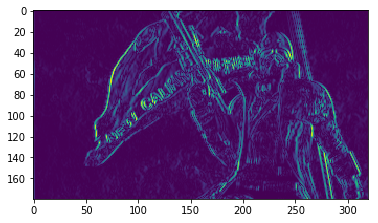

In [12]:
plt.imshow(normalize(img_edges))